## Set up

### Package imports

In [1]:
# Import packages
import re
import os
import gc
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import math
import random
import datetime
import time
import warnings
from pdb import set_trace
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
from torch import nn
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import models, transforms

### GPU

In [2]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 11.7


### Variables and Hyperparameters

In [3]:
# Create a timestamp for the summary file name
Time_Stamp = datetime.datetime.now().strftime("%Y_%m%d%_H%M")

# Create run name
Run_Name = 'final-1; Nov 7; Protein + mRNA; with weights' # change run_name before running

# Paths
dataset_folder_path = '/home/ec2-user/MLNotebook shared/Datasets/' # dataset folder with all the proteome and mRNA data
summary_folder_path = '/home/ec2-user/MLNotebook shared/Summary/' # summary folder path to store summary reports
model_folder_path = '/home/ec2-user/MLNotebook shared/Model exports/' # model folder path to store models
figure_folder_path = '/home/ec2-user/MLNotebook shared/Figure exports/' # figure folder path to store figures
performance_folder_path = '/home/ec2-user/MLNotebook shared/Performance DF exports/' # performance folder path to store performance dataframes

# Define the Model
Model = 'CustomNN-stride2' # 'ResNet18', 'CustomNN-reg', and 'CustomNN-stride2' are the options

# Define loss function
LossFunc_Name = 'CrossEntropy' # 'CrossEntropy', 'Focal' are the options

# Define the optimizer
Optim_Name = 'AdamW' # 'Adam', 'AdamW', 'SGD', 'SGD_weight' are the options

# Dataset
Set = 'Protein + mRNA' # Define the dataset to use, 'Protein', 'mRNA', or 'Protein + mRNA' are the options

# Image size
Canvas_Size = 18

# Seed number
Seed = 43

# Validation fraction
Validation_Fraction = 0.15

# Standard deviation for add-noise transformation
StandardDeviation = 0.05

# Learning rate scheduler
LrScheduler = True
Learner_rate = 1e-5

# Training set imbalance sampling method, can only choose one
ImbalanceSampler = False

# Optimizer
Weight_Decay = 0.0001 # L2 regulator
#  it works by adding a penalty to the loss function, which discourages large weights in the model; penalizes for too many weights - helps prevent overfitting
#  the penalty is calculated as weight_decay * weight^2, and it's added to the loss.
#  1e-4 or 1e-3 gives higher acc

Momentum = 0.9
#  specific for SGD optimizer, not applicable when using Adam optimizer
#  a way to smooth noise that is passed to the optimizer, 0.9
#  momentum is deterimental without label smoothing

# Loss Function (CrossEntropyLoss)
Label_Smoothing = 0.05
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

# Early stopping
Earlystopping = True

# Transformation
TransformOrNot = True

# Class weight to loss function
ApplyClassWeightToLoss = True
#  makes the loss weights equal to the fraction of each category label
#  note, a layer is added to the model so the outputs of the model are equal to the number of categories

# Batch size
batch = 64

# Epoch amount
epochs = 200

### Protein, mRNA dataframe, localization label set up

In [4]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
if Set == 'Protein':
    PFP = 'K_prot_PD_synthetic.csv' # synthetic data
elif Set == 'Protein + mRNA':
    PFP = 'K_prot+mRNA_PD_synthetic.csv' # synthetic data
else:
    PFP = None

if PFP is not None:
    PD = pd.read_csv(dataset_folder_path+PFP)

    # Data set wrangling
    PD.index = PD.loc[:,'Gene']
    PD = PD.loc[:,PD.columns!='Gene']
    PD.dropna(inplace=True)

    # Specific for krug raw ddamsproteomics, these 3 tumors are not in transcriptome data
    PD = PD.loc[:,PD.columns!='X11BR057']
    PD = PD.loc[:,PD.columns!='X11BR076']
    PD = PD.loc[:,PD.columns!='X11BR078']

    # Put values of each column in the DataFrame into a list
    values = np.sort(PD.values.flatten().tolist())

    #Find the 2.5 and 97.5 percentile
    percentile_high = np.percentile(values, 97.5)
    percentile_low = np.percentile(values, 2.5)

    # Use the percentile for normalization
    PD = (PD - percentile_low) / (percentile_high - percentile_low)

# Open the mRNA data and only keep genes (rows) that are fully quantified
if Set == 'mRNA':
    MFP = 'K_mRNA_MD_synthetic.csv' # mRNA file path, gene centric median normalized, log2 transformed
elif Set == 'Protein + mRNA':
    MFP = 'K_prot+mRNA_MD_synthetic.csv'
else:
    MFP = None

if MFP is not None:
    MD = pd.read_csv(dataset_folder_path + MFP)

    # Data set wrangling
    MD.index = MD.loc[:,'Gene']
    MD = MD.loc[:,MD.columns!='Gene']
    MD = MD.drop_duplicates()
    MD.dropna(inplace=True)

    # Put values of each column in the DataFrame into a list
    values = np.sort(MD.values.flatten().tolist())

    # Find the 2.5 and 97.5 percentile
    percentile_high = np.percentile(values, 97.5)
    percentile_low = np.percentile(values, 2.5)

    # Use the percentile for normalization
    MD = (MD - percentile_low) / (percentile_high - percentile_low)

In [5]:
# Open the labels data
LFP = 'SubCellBarcode.MCF7.txt'
LD = pd.read_csv(filepath_or_buffer=dataset_folder_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [6]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
if MFP is not None:
    IntersectingGenes = [value for value in PD.index if ((value in MD.index) & (value in LD.index))]
    PD = PD.loc[IntersectingGenes,:]
    MD = MD.loc[IntersectingGenes,:]
    LD = LD.loc[IntersectingGenes,:]

    # Sanity check for the number of genes in each dataframe
    print('Number of genes in Krug dataset')
    print(len(PD.index))
    print(len(MD.index))
    print(len(LD.index))

else:
    IntersectingGenes = [value for value in PD.index if value in LD.index]
    PD = PD.loc[IntersectingGenes,:]
    LD = LD.loc[IntersectingGenes,:]

    # Sanity check for the number of genes in each dataframe
    print('Number of genes in Krug dataset')
    print(len(PD.index))
    print(len(LD.index))

Number of genes in Krug dataset
4839
4839
4839


In [7]:
# Krug dataset label distribution
count = LD['Localization'].value_counts()

# Print out the label distribution
print('Krug label distribution:')
print(count)

Krug label distribution:
Localization
Cytosol         2121
Nuclear         1392
Secretory        991
Mitochondria     335
Name: count, dtype: int64


### Set seed function

In [8]:
def set_seed(seed):
    random.seed(seed) # set random seed for python
    np.random.seed(seed) # set random seed for numpy
    torch.manual_seed(seed) # set random seed for CPU
    rs = RandomState(MT19937(SeedSequence(seed))) # seed for numpy
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # set random seed for all GPUs
    torch.backends.cudnn.deterministic = True # set to True to get reproducible results
    torch.backends.cudnn.benchmark = False # set to False to get reproducible results

### Canvas and RGB tensor generation functions

In [9]:
def interleave_arrays(set=None, PD=None, MD=None):
    """
    Interleave the values from PD, MD and RD arrays if using both datasets and feature engineering, otherwise sort the PD or MD array.
    
    Parameters:
    set (str): Dataset used for plotting ('Protein', 'mRNA', 'Protein + mRNA').
    PD (pd.DataFrame): Array containing normalized protein abundance data.
    MD (pd.DataFrame): Array containing normalized mRNA abundance data.
    
    Returns:
    np.array: Interleaved array of PD and MD values if both are provided, otherwise sorted PD or MD array.
    """
    def sort_and_interleave(PD, MD=None):
        # Convert DataFrames to numpy arrays if necessary
        PD_array = PD.values if isinstance(PD, pd.DataFrame) else PD
        MD_array = MD.values if isinstance(MD, pd.DataFrame) else MD

        # Ensure PD and MD have compatible shapes
        assert PD_array.shape == MD_array.shape if MD_array is not None else True, \
            "PD and MD must have the same shape if both are provided."

        # Compute the sum for sorting if MD is provided, otherwise just use PD
        sum_abundance = PD_array + (MD_array if MD_array is not None else 0)

        # Sort indices by sum_abundance for each row
        sorted_indices = np.argsort(sum_abundance, axis=1)  # Ascending order

        # Sort PD and MD based on sorted indices
        try:
            PD_sorted = np.take_along_axis(PD_array, sorted_indices, axis=1)
            if MD_array is not None:
                MD_sorted = np.take_along_axis(MD_array, sorted_indices, axis=1)
                return PD_sorted, MD_sorted
            else:
                return PD_sorted, None
        except IndexError as e:
            print("IndexError in sort_and_interleave:")
            print(f"PD_array shape: {PD_array.shape}, MD_array shape: {MD_array.shape if MD_array is not None else 'None'}")
            print(f"sorted_indices shape: {sorted_indices.shape}")
            raise e

    if set == 'Protein + mRNA':
        assert PD.shape == MD.shape, "PD and MD dataframes must have the same shape."
        PD_sorted, MD_sorted = sort_and_interleave(PD, MD)
        
        interleaved_array = np.empty((len(PD_sorted), Canvas_Size*Canvas_Size), dtype=PD_sorted.dtype)
        interleaved_array[:, 0::2] = PD_sorted
        interleaved_array[:, 1::2] = MD_sorted
        return interleaved_array

    elif set == 'Protein':
        assert PD is not None and MD is None, "PD dataframe must be provided."
        PD_sorted, _ = sort_and_interleave(PD)
        return PD_sorted

    elif set == 'mRNA':
        assert MD is not None and PD is None, "MD dataframe must be provided."
        MD_sorted, _ = sort_and_interleave(MD)
        return MD_sorted
    
    else:
        raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")

def gen_horizontal_coords(n, num_points):
    """
    Generate coordinates for a horizontal pattern starting from the top-left corner.

    Parameters:
    n (int): Size of the canvas (n x n).
    num_points (int): Number of points to generate in the horizontal pattern.

    Returns:
    list: List of (x, y) coordinates in horizontal order.
    """
    coords = [(x, y) for x in range(n) for y in range(n)]
    return coords[:num_points]

def create_rgb_tensors(set, PD, MD):
    """
    Create RGB tensors from PD and MD data using the specified pattern.
    
    Parameters:
    PD (pd.DataFrame): DataFrame containing normalized protein abundance data.
    MD (pd.DataFrame): DataFrame containing normalized mRNA abundance data.
    pattern (str): Pattern to use for arranging the data ('spiral').
    
    Returns:
    torch.Tensor: RGB tensor.
    """

    final_array = interleave_arrays(set, PD, MD)
    final_array = final_array.flatten()
    num_pixels = len(final_array)
    
    # Generate coordinates based on the pattern, spiral or horizontal arrangment
    coords = gen_horizontal_coords(Canvas_Size, num_pixels)

    # Create RGB tensor
    rgb_tensor = np.zeros((Canvas_Size, Canvas_Size, 3), dtype=np.float32)
    for i, (x, y) in enumerate(coords):
        if i < len(final_array):
            value = final_array[i]
            # Assign colors based on the value, if abundance > 1, set it to red, if abundance < 0, set it to blue.
            if value > 1:
                rgb_tensor[x, y] = [255, 0, 0]  # Red for value > 1
            elif value < 0:
                rgb_tensor[x, y] = [0, 0, 255]  # Blue for value < 0
            else:
                rgb_tensor[x, y] = [255 * value, 0, 255 * (1 - value)]

    return torch.from_numpy(rgb_tensor.transpose(2, 0, 1))  # Convert to CHW format for PyTorch

### Transformation class

In [10]:
class NoiseTransform:
    """
    A class that applies normal noise transformation to a DataFrame.

    Args:
        mean (float): The mean of the normal distribution. Default is 0.
        std_dev (float): The standard deviation of the normal distribution. Default is 0.2.
    """

    def __init__(self, mean=0, std_dev=StandardDeviation):
        super(NoiseTransform, self).__init__()
        self.mean = mean
        self.std_dev = std_dev

    def forward(self, df):
        """
        Applies normal noise transformation to the input DataFrame.

        Args:
            df (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The transformed DataFrame with normal noise applied.
        """
        tensor = torch.from_numpy(df.values).float()
        noise = torch.empty(tensor.size()).normal_(self.mean, self.std_dev)
        noisy_tensor = tensor + noise
        noisy_tensor = noisy_tensor.clamp(0, 1) # Clamp the values of noisy_tensor between 0 and 1
        
        # Convert the tensor back to DataFrame
        df_transformed = pd.DataFrame(noisy_tensor.numpy(), index=df.index, columns=df.columns)
        
        return df_transformed

In [11]:
class CombinedTransform:
    """
    A class representing a combined transformation.

    Args:
        set: The dataset used for the transformation.
        transform1: The first transformation to apply.
        transform2: The second transformation to apply (optional).
        FeatureEngineering: Whether to use the feature engineering data.

    Attributes:
        transform1: The first transformation.
        transform2: The second transformation.
        FeatureEngineering: Whether to use the feature engineering data.

    Methods:
        __call__: Applies the combined transformation to the input dataframes.

    """

    def __init__(self, set, transform1=None, transform2=None):
        self.set = set
        self.transform1 = transform1 if transform1 is not None else None
        self.transform2 = transform2 if transform2 is not None else None

    def __call__(self, set, df1, df2):
        """
        Applies the combined transformation to the input dataframes.

        Args:
            set: The dataset used for the transformation.
            df1: The first dataframe.
            df2: The second dataframe.

        Returns:
            transformed_rgb_tensors: The transformed RGB tensors.

        """

        # apply the first transformation (noise) to df1 and df2; df1 is PD, df2 is MD
        if self.transform1 is not None:
            df1 = self.transform1.forward(df1) if df1 is not None else None
            df2 = self.transform1.forward(df2) if df2 is not None else None
            
        # apply the second transformation (random column) to df1 and df2
        if self.transform2 is not None:
            df1, df2 = self.transform2.forward(df1, df2) if df1 is not None and df2 is not None else (None, None)
        
        # if we are using feature engineering, derive third dataframe from already noise and/or column random transformed 
        if self.set == 'Protein':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, None)
        elif self.set == 'mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, None, df2)
        elif self.set == 'Protein + mRNA':
            transformed_rgb_tensors = create_rgb_tensors(self.set, df1, df2)
        
        if transformed_rgb_tensors is None:
            raise ValueError("Set must be 'Protein', 'mRNA', or 'Protein + mRNA'")
                
        return transformed_rgb_tensors

### Dataset class

In [12]:
class MyDataset(Dataset):
    def __init__(self, set, PD, MD, labels, transform=None):
        self.set = set
        self.PD = PD if PD is not None else None
        self.MD = MD if MD is not None else None
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        pd_data = self.PD.iloc[idx].to_frame().T if self.PD is not None else None
        md_data = self.MD.iloc[idx].to_frame().T if self.MD is not None else None
        label = self.labels[idx]

        if self.transform:  
            if self.set == 'Protein + mRNA':
                tensor = self.transform(self.set, pd_data, md_data)
            elif self.set == 'Protein':
                tensor = self.transform(self.set, pd_data, None)
            elif self.set == 'mRNA':
                tensor = self.transform(self.set, None, md_data)

        else:
            if self.set == 'Protein + mRNA':
                tensor = create_rgb_tensors(self.set, pd_data, md_data)
            elif self.set == 'Protein':
                tensor = create_rgb_tensors(self.set, pd_data, None)
            elif self.set == 'mRNA':
                tensor = create_rgb_tensors(self.set, None, md_data)

        # Ensure tensor is not None
        if tensor is None:
            raise ValueError("Both PD and MD are None, cannot create tensor.")

        return tensor, label

    def __len__(self):
        return len(self.labels)

    def get_labels(self):
        return self.labels

## Model training

### Apply transformations

In [13]:
# Create an instance of the transform
noise_transform = NoiseTransform()

# Create an instance of the combined transform， change here if doing different transformation
# Transform 1 default is noise_transform, transform 2 default is TBD
transform = CombinedTransform(set=Set, transform1=noise_transform, transform2=None)

### Dataloaders

In [ ]:
# Set seed to ensure reproducibility
set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label dataframe
labels = encoder.fit_transform(LD.values.ravel())

# Convert the labels to tensors
labels = torch.tensor(labels)

# Split the data into training and validation sets using the labels indices, random state is set
indices = range(len(labels))
train_indices, val_indices, train_labels, val_labels = train_test_split(indices, labels, test_size=Validation_Fraction, random_state=42)

# Use the indices to split PD and MD
if PFP is not None:
    if Set == 'Protein' or 'Protein + mRNA':
        train_PD = PD.iloc[train_indices]
        val_PD = PD.iloc[val_indices]
        print('Proteome data set is splited')
if MFP is not None:
    if Set == 'mRNA' or 'Protein + mRNA':
        train_MD = MD.iloc[train_indices]
        val_MD = MD.iloc[val_indices]
        print('mRNA data set is splited')

## Create the datasets
# Initialize transform to None
transform_to_use = None

# Check if transformations should be applied
if TransformOrNot:
    transform_to_use = transform # transform is defined above

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    train_dataset = MyDataset(Set, train_PD, None, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, None, val_labels, transform=None)
elif Set == 'mRNA':
    train_dataset = MyDataset(Set, None, train_MD, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, None, val_MD, val_labels, transform=None)
elif Set == 'Protein + mRNA':
    train_dataset = MyDataset(Set, train_PD, train_MD, train_labels, transform=transform_to_use)
    val_dataset = MyDataset(Set, val_PD, val_MD, val_labels, transform=None)
else:
    raise ValueError("Set must be 'Protein' or 'mRNA', or 'Protein + mRNA'")

# Create the training data loaders, iteration of each index happens here
if ImbalanceSampler:
    train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, sampler=ImbalancedDatasetSampler(train_dataset))
    print('Train dataloader is balanced by ImbalancedDatasetSampler')
else:
    train_dataloader = DataLoader(train_dataset, batch_size = batch, shuffle=True) ##############
    print('Train dataloader is not balanced by ImbalancedDatasetSampler')


# Create the validation data loader, shuffling is not necessary
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
print('Validation dataloader is not shuffled')

Proteome data set is splited
mRNA data set is splited
Train dataloader is not balanced by ImbalancedDatasetSampler
Validation dataloader is not shuffled


### Check quantity of each label in dataloaders

In [15]:
# Print out the labels corresponding to each class
for i, label in enumerate(encoder.classes_):
    print(f"{i} is {label}")

# Initialize a Counter object
train_class_counts = Counter()

# Iterate over the DataLoader
for _, labels in train_dataloader:
    # Update the Counter with the labels in the current batch
    train_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Training set label counts: {sorted(train_class_counts.items())}")

# Initialize a Counter object
val_class_counts = Counter()

# Iterate over the DataLoader
for _, labels in val_dataloader:
    # Update the Counter with the labels in the current batch
    val_class_counts.update(labels.numpy())

# Print the class distribution
print(f"Validation set label counts: {sorted(val_class_counts.items())}")

0 is Cytosol
1 is Mitochondria
2 is Nuclear
3 is Secretory
Training set label counts: [(0, 1804), (1, 284), (2, 1189), (3, 836)]
Validation set label counts: [(0, 317), (1, 51), (2, 203), (3, 155)]


### Visualize the tensors in data loader

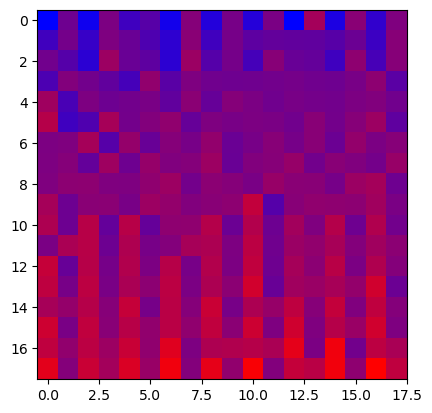

In [16]:
# Visualize the train data loader to see the transformed tensors
train_batch_images, train_batch_labels = next(iter(train_dataloader))

# Use first image in the batch
first_image_in_train_batch = train_batch_images[0]
image_to_plot = first_image_in_train_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_train_batch = train_batch_labels[0]

# Visualize the tensor as an image 
plt.imshow(image_to_plot)

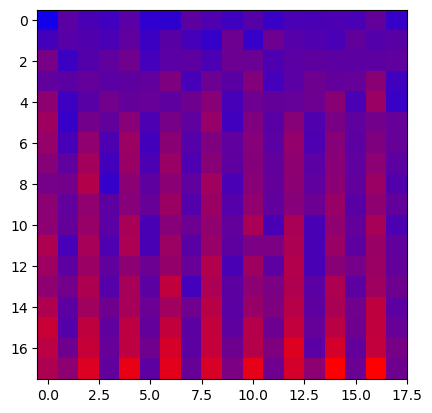

In [17]:
# Visualize the train data loader to see the transformed tensors
val_batch_images, val_batch_labels = next(iter(val_dataloader))

# Use first image in the batch
first_image_in_val_batch = val_batch_images[0]
image_to_plot = first_image_in_val_batch.permute(1, 2, 0).numpy().astype('uint8')
first_label_in_val_batch = val_batch_labels[0]

# Visualize the tensor as an image
plt.imshow(image_to_plot)

### Sanity check

In [18]:
# For recording the time and double check the sets before running
print(Time_Stamp)
print(f'Dataset: {Set}')
print(f'Image size: {Canvas_Size} x {Canvas_Size}')

2024_1107 526
Dataset: Protein + mRNA
Image size: 18 x 18


### CustomNN class

In [19]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()

        # Dropout percentage for the model
        self.dropout_percentage = 0.3

        # Initial layer: 2x2 kernel, stride 1 (input 18x18 -> output 17x17)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(2, 2), stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(64)

        # Conv2: 2x2 kernel, stride 1 (output 16x16)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(128)

        # Conv3: 2x2 kernel, stride 1 (output 15x15)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(256)

        # Conv4: 2x2 kernel, stride 2 (output 7x7)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(512)

        # Conv5: 3x3 kernel, stride 1 (output 5x5)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(1024)

        # Conv6: 2x2 kernel, stride 1 (output 4x4)
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(2, 2), stride=1, padding=0)
        self.bn6 = nn.BatchNorm2d(512)
        self.dropout6 = nn.Dropout(p=self.dropout_percentage)  # Dropout after conv6

        # Conv7: 2x2 kernel, stride 2 (output 2x2)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(2, 2), stride=2, padding=0)
        self.bn7 = nn.BatchNorm2d(512)
        self.dropout7 = nn.Dropout(p=self.dropout_percentage)  # Dropout after conv7

        # Adaptive Average Pooling (output 1x1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Linear(512, 1000)
        self.fc_dropout = nn.Dropout(p=self.dropout_percentage)  # Dropout after fully connected layer
        self.out = nn.Linear(1000, 4)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))  # Output: 64 channels, 17x17

        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))  # Output: 128 channels, 16x16

        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))  # Output: 256 channels, 15x15

        # Fourth conv block with downsampling
        x = F.relu(self.bn4(self.conv4(x)))  # Output: 512 channels, 7x7

        # Fifth conv block
        x = F.relu(self.bn5(self.conv5(x)))  # Output: 512 channels, 5x5

        # Sixth conv block with dropout
        x = F.relu(self.bn6(self.conv6(x)))  # Output: 512 channels, 4x4
        x = self.dropout6(x)

        # Seventh conv block with dropout
        x = F.relu(self.bn7(self.conv7(x)))  # Output: 512 channels, 2x2
        x = self.dropout7(x)

        # Global Average Pooling to reduce size to 1x1
        x = self.avgpool(x)  # Output: 512 channels, 1x1

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc(x))
        x = self.fc_dropout(x)  # Dropout after fully connected layer
        x = self.out(x)

        return x

In [20]:
# Model with initial stride of 2
class SimpleResNet2(nn.Module):
    def __init__(self):
        super(SimpleResNet2, self).__init__()

        # Dropout percentage for the model
        self.dropout_percentage = 0.5

        # Conv1: 2x2 kernel, stride 2 (input 18x18 -> output 9x9)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(2, 2), stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)

        # Conv2: 2x2 kernel, stride 1 (output 8x8)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(128)

        # Conv3: 2x2 kernel, stride 1 (output 7x7)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(p=0.3)  # Dropout after conv3

        # Conv4: 2x2 kernel, stride 2 (output 3x3)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(2, 2), stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout(p=0.3)  # Dropout after conv4

        # Conv5: 3x3 kernel, stride 1 (output 1x1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(1024)
        self.dropout5 = nn.Dropout(p=0.4)  # Dropout after conv5

        # Conv6: 2x2 kernel, stride 1 (remains 1x1)
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(1, 1), stride=1, padding=0)
        self.bn6 = nn.BatchNorm2d(512)
        self.dropout6 = nn.Dropout(p=self.dropout_percentage)  # Dropout after conv6

        # Conv7: 2x2 kernel, stride 2 (remains 1x1)
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1, 1), stride=1, padding=0)
        self.bn7 = nn.BatchNorm2d(512)
        self.dropout7 = nn.Dropout(p=self.dropout_percentage)  # Dropout after conv7

        # Adaptive Average Pooling (output 1x1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc = nn.Linear(512, 1000)
        self.fc_dropout = nn.Dropout(p=self.dropout_percentage)  # Dropout after fully connected layer
        self.out = nn.Linear(1000, 4)

    def forward(self, x):
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))  # Output: 64 channels, 9x9

        # Second conv block
        x = F.relu(self.bn2(self.conv2(x)))  # Output: 128 channels, 8x8

        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))  # Output: 256 channels, 7x7
        x = self.dropout3(x)

        # Fourth conv block with downsampling
        x = F.relu(self.bn4(self.conv4(x)))  # Output: 512 channels, 3x3
        x = self.dropout4(x)

        # Fifth conv block
        x = F.relu(self.bn5(self.conv5(x)))  # Output: 1024 channels, 1x1
        x = self.dropout5(x)
        
        # Sixth conv block with dropout
        x = F.relu(self.bn6(self.conv6(x)))  # Output: 512 channels, 1x1
        x = self.dropout6(x)

        # Seventh conv block with dropout
        x = F.relu(self.bn7(self.conv7(x)))  # Output: 512 channels, 1x1
        x = self.dropout7(x)

        # Global Average Pooling to reduce size to 1x1
        x = self.avgpool(x)  # Output: 512 channels, 1x1

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc(x))
        x = self.fc_dropout(x)  # Dropout after fully connected layer
        x = self.out(x)

        return x

### Training and testing epoch loop functions

In [21]:
# Function for training the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    gradient_norms = []
    
    for batch, (X, y) in enumerate(dataloader):

        # Prepare data
        X = X.to(torch.float32) # convert to float32 to avoid error stating byte expected but found float
        X = X.to(device)
        y = y.to(device)

        # Forward pass: predict classes
        pred = model(X)
    
        # Compute the cross-entropy loss 
        loss = loss_fn(pred, y)

        # Compute the softmax probabilities
        softmax_probs = F.softmax(pred, dim=1)

        # Compute the entropy of the softmax output for the confidence penalty
        entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + 1e-10), dim=1)

        # Confidence penalty: encourage high entropy (i.e., reduce overconfidence)
        penalty = torch.mean(entropy)
        
        # Total loss: cross-entropy loss + confidence penalty (scaled by lambda); lambda set to 0.1
        total_loss_with_penalty = loss - 0.1 * penalty

        # Backpropagation
        optimizer.zero_grad() # zero the parameter gradients 
        total_loss_with_penalty.backward() # backpropagate the loss

        # Compute gradient norms for each parameter
        batch_gradient_norms = []
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()  # Compute L2 norm
                batch_gradient_norms.append((name, grad_norm))
        
        # Log or print the gradient norms for this batch
        gradient_norms.append(batch_gradient_norms)  # Store gradient norms to analyze later
        
        # Step the optimizer
        optimizer.step() # adjust parameters based on the calculated gradients

        # Accumulate loss
        total_loss += loss.item() # extract the loss value

        # Get the current learing rate
        current_lr = optimizer.param_groups[0]['lr']

    # Update the learning rate scheduler
    if LrScheduler:
        exp_lr_scheduler.step()   

    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, current_lr, gradient_norms
            
# Function for validating the model
def test_loop(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy = 0, 0
    
    for X, y in dataloader:
        
        # Prepare data
        X = X.to(torch.float32)
        X = X.to(device)
        y = y.to(device)

        # Forward pass: predict classes
        pred = model(X)
        
        # Compute the softmax probabilities
        softmax_probs = F.softmax(pred, dim=1)

        # # Compute the loss
        test_loss += loss_fn(pred, y).item()

        # Calculate accuracy: choose the class with the highest probability
        accuracy += (softmax_probs.argmax(1) == y).type(torch.float).sum().item()
        #accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy /= size
        
    return test_loss, accuracy

# Function for testing the model with confusion matrix, and softmax output with a condition of >50% certanty
def test_loop_with_confusion_matrix(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, accuracy, no_prediction_count = 0, 0, 0
    
    all_preds = []
    all_labels = []
    
    for X, y in dataloader:
        # convert to float32 to avoid byte/float mismatch error
        X = X.to(torch.float32)
        X = X.to(device)
        pred = model(X)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(pred, dim=1)
        
        # Get the maximum probability and its corresponding class
        max_prob, predicted_class = torch.max(probabilities, dim=1)
        
        # Only consider predictions with a probability greater than 0.5
        valid_predictions = max_prob > 0.5
        
        # Convert the labels to the same device and calculate the loss
        y = y.to(device)
        test_loss += loss_fn(pred, y).item()
        
        # Append valid predictions and corresponding labels to lists for confusion matrix
        all_preds.extend(predicted_class[valid_predictions].cpu().numpy())
        all_labels.extend(y[valid_predictions].cpu().numpy())
        
        # Count valid predictions where probability is greater than 0.5
        valid_preds_count = valid_predictions.sum().item()
        
        # Calculate accuracy only for valid predictions
        accuracy += (predicted_class[valid_predictions] == y[valid_predictions]).type(torch.float).sum().item()
        
        # Count how many predictions were skipped (i.e., where no probability exceeded 0.5)
        no_prediction_count += (valid_predictions == 0).sum().item()

        # Calculate the precision and recall
        precision = precision_score(all_labels, all_preds, average=None, zero_division=0.0)
        recall = recall_score(all_labels, all_preds, average=None, zero_division=0.0)

    test_loss /= num_batches
    if size == no_prediction_count:
        accuracy = 0
    else:
        accuracy /= (size - no_prediction_count)  # Normalize accuracy by valid predictions
    no_prediction_percentage = no_prediction_count / size * 100

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Skipped predictions (no class > 50%): {no_prediction_percentage:.2f}%")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    return test_loss, accuracy, conf_matrix, precision, recall

### Confusion matrix, precision and recall calculation helper function

In [22]:
# Function to calculate the precision and recall
def calculate_precision_recall(dataloader, model):
    y_pred = []
    y_true = []

    # iterate over validation data
    for X, y in dataloader:
        
        X = X.to(torch.float32)
        X = X.to(device)
        output = model(X)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # Save Prediction

        labels = y.cpu().numpy()
        y_true.extend(labels)  # Save Truth

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Calculate precision and recall for each class
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)

    return cf_matrix, precision, recall

### F1 score helper function

In [23]:
def calculate_f1_metrics(conf_matrix):
    # True positives are the diagonal elements
    tp = np.diag(conf_matrix)
    # False positives are the sum of each column minus the diagonal element
    fp = np.sum(conf_matrix, axis=0) - tp
    # False negatives are the sum of each row minus the diagonal element
    fn = np.sum(conf_matrix, axis=1) - tp
    # True negatives are the sum of all elements minus the sum of the corresponding row and column plus tp
    tn = conf_matrix.sum() - (fp + fn + tp)
    
    # Precision, recall, and F1 score calculations
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    # Return macro-averaged F1 score (excluding NaNs caused by divisions by zero)
    return np.nanmean(f1)

### Define early stopping

In [24]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved.
            min_delta (float): Minimum change in validation loss to qualify as an improvement.
            verbose (bool): If True, prints a message for each improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter if there's an improvement

### Define loss functions and class weights 

In [25]:
# Focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        :param gamma: focusing parameter (default=2.0)
        :param alpha: balance parameter, it can be a float or a tensor (default=None)
        :param reduction: specify the reduction to apply to the output: 'none' | 'mean' | 'sum' (default='mean')
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross-entropy loss
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the true class
        
        # Compute the focal loss
        F_loss = (1 - pt) ** self.gamma * BCE_loss
        
        # Apply class weighting (alpha) if provided
        if self.alpha is not None:
            alpha = self.alpha[targets]
            F_loss = alpha * F_loss
        
        # Apply the specified reduction
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [26]:
# Loss function
# https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75
if ApplyClassWeightToLoss:
    # Weights for each class for loss function
    LossWeights = torch.tensor([0.822,2.655,1.239,1.601]) # calculate by log inverse class frequency np.log(total/(# + 1)), it's better
    # LossWeights = torch.tensor([0.569, 3.571, 0.864, 1.241]) # inverse class frequency weight wj=N/(nj*4)
    # LossWeights = torch.tensor([0.569, 3.559, 0.864, 1.239]) # inverse class frequency weight smoothed wj=(N+smooth)/(nj+smooth*4)
    # LossWeights = torch.tensor([1.000, 2.836, 1.417, 1.779]) # log scaling wj=1+(log(max(majority class))/nj)
    # LossWeights = torch.tensor([1.139, 7.142, 1.728, 2.481]) # balanced weight wj = N/(nj*2)
    
    LossWeights = LossWeights.to(device)
    
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing, weight=LossWeights)

    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=torch.exp(LossWeights)/torch.exp(LossWeights).sum(), reduction='mean') # Result: tensor([0.1213, 0.5296, 0.1916, 0.1576])

else:
    if LossFunc_Name == 'CrossEntropy':
        loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)
    
    elif LossFunc_Name == 'Focal':
        loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

### Define the model

In [27]:
# Define the model
if Model == 'ResNet18': # Resnet18
    model = models.resnet18(weights=None) # without initial weights defined - good for patients not re-arranged
    model.fc = nn.Sequential(
        model.fc,
        nn.Dropout(0.5),
        nn.Linear(1000, 4))

elif Model == 'CustomNN-reg':
    model = SimpleResNet() # for 18x18

elif Model == 'CustomNN-stride2':
    model = SimpleResNet2() # for 18x18 with initial stride 2

elif Model == 'CustomNN-mini':
    model = SimpleResNet_Mini() # for 12x12

model = model.to(dev)

# see the model architecture if desired
print(model)

SimpleResNet2(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.3, inplace=False)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout5): Dropout(p=0.4, inplace=False)
  (conv6): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
  (bn6): BatchNorm2d(512, e

### Define the optimizer

In [28]:
# Define the optimizer
def Optimizer(name, model):
    if name == 'SGD_weight':
        optimizer = torch.optim.SGD(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay, momentum=Momentum)
    if name == 'SGD_default':
        optimizer = torch.optim.SGD(model.parameters(), lr=Learner_rate)
    if name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)
    if name == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=Learner_rate, betas=(0.9, 0.999), weight_decay=Weight_Decay)
        
    return optimizer

# call optimizer
optimizer = Optimizer(Optim_Name, model)

### Learner rate finder

In [29]:
# from torch_lr_finder import LRFinder
# amp_config = {
#     'device_type': 'cuda',
#     'dtype': torch.float32,
# }
# optimizer = torch.optim.AdamW(model.parameters(), lr=Learner_rate, betas=(0.9,0.999), weight_decay=Weight_Decay)
# grad_scaler = torch.cuda.amp.GradScaler()
# lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda", amp_backend='torch', amp_config=amp_config, grad_scaler=grad_scaler)
# lr_finder.range_test(train_dataloader, end_lr=1, num_iter=5000, step_mode='exp')
# lr_finder.plot()
# lr_finder.reset()

### Define the learning rate scheduler

In [30]:
# Define LR scheduler
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# Define the cosine annealing scheduler
# exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)

# Define the cosine annealing warm restarts scheduler
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=0.01*Learner_rate) # 1% of initial learning rate as minimum

### Run the model

In [31]:
# Set the seed for reproducibility
set_seed(Seed)

# Set up performance dataframe to record loss and accuracy of each epoch
PerformanceDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
print(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}{'Current LR':>13s}\n")
PrecisionRecallDF = pd.DataFrame(columns=['Epoch', 'Class', 'Precision', 'Recall'])
index = 0
current_lr = Learner_rate

# Initialize early stopping
if Earlystopping == True:
    early_stopping = EarlyStopping(patience=30, min_delta=0.0001, verbose=True)

# epochs
for t in range(epochs+1):

    if t == 0:
        # get initial model losses, accuracies from both training and validation sets
        train_loss, train_accuracy = test_loop(train_dataloader, model, loss_fn)
        val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
        
        # get initial model precision and recall for each class
        val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)

    else:
        # training the model, output the losses, get the training and validation accuracy on the fly
        model.train()
        train_loss, current_lr, gradient_norms = train_loop(train_dataloader, model, loss_fn, optimizer)
        _, train_accuracy = test_loop(train_dataloader, model, loss_fn)

        model.eval()
        with torch.no_grad():
            val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
            val_cf_matrix, precision, recall = calculate_precision_recall(val_dataloader, model)
        
    Epoch = t
    print(f"{str(Epoch):>5s}{train_loss:>13f}{val_loss:>11f}{train_accuracy:>16f}{val_accuracy:>14f}{current_lr:>16f}")
    PerformanceDF.loc[t,:]=[Epoch,train_loss,val_loss,train_accuracy,val_accuracy]
    for i in range(4):
        PrecisionRecallDF.loc[index]=[Epoch, i, precision[i], recall[i]]
        index += 1
    
    if t == 0:
        highest_val_accuracy = 0 
        MSD0 = copy.deepcopy(model.state_dict())

    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        MSD_Best = copy.deepcopy(model.state_dict())
        # Record the epoch when the best model is saved
        Best_Epoch = t
        torch.save({
            'model_state_dict': MSD_Best,
            'optimizer_state_dict': optimizer.state_dict()}, 
            Path(model_folder_path + f'best_model_{Run_Name}_{Time_Stamp}.pth'))

    if t == epochs:
        MSD_Final = copy.deepcopy(model.state_dict())
        torch.save({
            'model_state_dict': MSD_Final,
            'optimizer_state_dict': optimizer.state_dict()}, 
            Path(model_folder_path + f'last_model_{Run_Name}_{Time_Stamp}.pth'))
    
    # Check for early stopping
    if Earlystopping == True:
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break  # Stop the training loop if early stopping is triggered
    
print("Done!")

Epoch   Train Loss   Val Loss   Train Accuracy   Val Accuracy   Current LR

    0     1.458500   1.467283        0.216630      0.206612        0.000010
    1     1.442341   1.395137        0.297593      0.422865        0.000010
    2     1.415200   1.389403        0.309993      0.431129        0.000010
    3     1.412741   1.386418        0.318259      0.439394        0.000010
    4     1.411187   1.383136        0.317044      0.443526        0.000010
    5     1.398553   1.380736        0.334792      0.440771        0.000010
    6     1.399383   1.377551        0.342086      0.453168        0.000010
    7     1.401136   1.376723        0.332847      0.455923        0.000010
    8     1.396036   1.372810        0.341843      0.458678        0.000010
    9     1.390728   1.369986        0.343059      0.460055        0.000009
   10     1.390141   1.367036        0.356674      0.469697        0.000009
   11     1.376514   1.363424        0.364211      0.465565        0.000009
   12     1.

In [32]:
Best_Epoch

199

## Testing set prepration

### Dataloaders

In [33]:
# Read in the synthetic data
if Set == 'Protein + mRNA':
    # Johansson
    J_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot+mRNA_PD_synthetic.csv'))
    J_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot+mRNA_MD_synthetic.csv'))
    
    # Mertins
    M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot+mRNA_PD_synthetic.csv'))
    M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot+mRNA_MD_synthetic.csv'))

    # Krug
    K_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'K_prot+mRNA_PD_synthetic.csv'))
    K_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'K_prot+mRNA_MD_synthetic.csv'))

    # Wrangling
    J_PD_synthetic.index = J_PD_synthetic.loc[:,'Unnamed: 0']
    J_MD_synthetic.index = J_MD_synthetic.loc[:,'Unnamed: 0']
    M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
    M_MD_synthetic.index = M_MD_synthetic.loc[:,'Unnamed: 0']

    J_PD_synthetic = J_PD_synthetic.loc[:, J_PD_synthetic.columns!='Unnamed: 0']
    J_MD_synthetic = J_MD_synthetic.loc[:, J_MD_synthetic.columns!='Unnamed: 0']
    M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']
    M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='Unnamed: 0']

    K_PD_synthetic.index = K_PD_synthetic.loc[:,'Gene']
    K_MD_synthetic.index = K_MD_synthetic.loc[:,'Gene']
    K_PD_synthetic = K_PD_synthetic.loc[:, K_PD_synthetic.columns!='Gene']
    K_MD_synthetic = K_MD_synthetic.loc[:, K_MD_synthetic.columns!='Gene']
    
    print(f"Set is 'Protein + mRNA'")

elif Set == 'Protein':
    # Johansson
    J_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_prot_PD_synthetic.csv'))
    J_PD_synthetic.index = J_PD_synthetic.loc[:,'Unnamed: 0']
    J_PD_synthetic = J_PD_synthetic.loc[:, J_PD_synthetic.columns!='Unnamed: 0']

    # Mertins
    M_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_prot_PD_synthetic.csv'))
    M_PD_synthetic.index = M_PD_synthetic.loc[:,'Unnamed: 0']
    M_PD_synthetic = M_PD_synthetic.loc[:, M_PD_synthetic.columns!='Unnamed: 0']

    # Krug
    K_PD_synthetic = pd.read_csv(Path(dataset_folder_path+'K_prot_PD_synthetic.csv'))
    K_PD_synthetic.index = K_PD_synthetic.loc[:,'Gene']
    K_PD_synthetic = K_PD_synthetic.loc[:, K_PD_synthetic.columns!='Gene']
    print(f"Set is 'Protein'")

elif Set == 'mRNA':
    # Johansson
    J_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'J_mRNA_MD_synthetic.csv'))
    J_MD_synthetic.index = J_MD_synthetic.loc[:,'Unnamed: 0']
    J_MD_synthetic = J_MD_synthetic.loc[:, J_MD_synthetic.columns!='Unnamed: 0']

    # Mertins
    M_MD_synthetic = pd.read_csv(Path(dataset_folder_path+'M_mRNA_MD_synthetic.csv'))
    M_MD_synthetic.index = M_MD_synthetic.loc[:,'Unnamed: 0']
    M_MD_synthetic = M_MD_synthetic.loc[:, M_MD_synthetic.columns!='Unnamed: 0']

    print(f"Set is 'mRNA'")

Set is 'Protein + mRNA'


In [34]:
# Read in the label
J_LD = pd.read_csv(Path(dataset_folder_path+'Johansson_Localization.csv')) # gene labels that are mutual in proteome and transcriptome
M_LD = pd.read_csv(Path(dataset_folder_path+'Mertins_Localization.csv')) # gene labels that are mutual in proteome and transcriptome
K_LD = pd.read_csv(Path(dataset_folder_path+'SubCellBarcode.MCF7.txt'), sep='\t') # gene labels that are mutual in proteome and transcriptome
# Data set wrangling
J_LD.index = J_LD.loc[:,'Protein']
J_LD = J_LD.loc[:,J_LD.columns!='Protein']
M_LD.index = M_LD.loc[:,'Protein']
M_LD = M_LD.loc[:,M_LD.columns!='Protein']
K_LD.index = K_LD.loc[:,'Protein']
K_LD = K_LD.loc[:,K_LD.columns!='Protein']
# Remove unclassified in K_LD
NotUnclassInd = K_LD.loc[:,'Localization'] != 'Unclassified'
K_LD = K_LD.loc[NotUnclassInd,:]

# Filter out the common genes in K_LD and K_PD_synthetic
CommonGenes = K_PD_synthetic.index.intersection(K_LD.index)
K_PD_synthetic = K_PD_synthetic.loc[CommonGenes,:]
K_LD = K_LD.loc[CommonGenes,:]

In [35]:
# Count labels and report the count and percentage
J_LD_count = J_LD.value_counts()
J_LD_percentage = J_LD.value_counts(normalize=True)
M_LD_count = M_LD.value_counts()
M_LD_percentage = M_LD.value_counts(normalize=True)

# Print the label count and percentage
print(f'Johansson label count:\n{J_LD_count}\n')
print(f'Johansson label percentage:\n{J_LD_percentage}\n')
print(f'Mertins label count:\n{M_LD_count}\n')
print(f'Mertins label percentage:\n{M_LD_percentage}\n')

Johansson label count:
Localization
Cytosol         3279
Nuclear         2179
Secretory       1967
Mitochondria     564
Name: count, dtype: int64

Johansson label percentage:
Localization
Cytosol         0.410439
Nuclear         0.272750
Secretory       0.246214
Mitochondria    0.070597
Name: proportion, dtype: float64

Mertins label count:
Localization
Cytosol         2421
Nuclear         1407
Secretory        870
Mitochondria     378
Name: count, dtype: int64

Mertins label percentage:
Localization
Cytosol         0.476950
Nuclear         0.277187
Secretory       0.171395
Mitochondria    0.074468
Name: proportion, dtype: float64



In [37]:
# Set the seed for reproducibility
set_seed(Seed)

# Create a LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels to integers from LD, the label df
J_labels = encoder.fit_transform(J_LD.values.ravel())
M_labels = encoder.fit_transform(M_LD.values.ravel())
K_labels = encoder.fit_transform(K_LD.values.ravel())

# Convert the labels to tensors
J_labels = torch.tensor(J_labels)
M_labels = torch.tensor(M_labels)
K_labels = torch.tensor(K_labels)

# Check Dataset argument to determine which dataset to use
if Set == 'Protein':
    J_test_dataset = MyDataset(Set, J_PD_synthetic, None, J_labels, transform=None)
    M_test_dataset = MyDataset(Set, M_PD_synthetic, None, M_labels, transform=None)
    K_test_dataset = MyDataset(Set, K_PD_synthetic, None, K_labels, transform=None)
    print('Protein dataset loaded')
elif Set == 'mRNA':
    J_test_dataset = MyDataset(Set, None, J_MD_synthetic, J_labels, transform=None)
    M_test_dataset = MyDataset(Set, None, M_MD_synthetic, M_labels, transform=None)
    print('mRNA dataset loaded')
elif Set == 'Protein + mRNA':
    J_test_dataset = MyDataset(Set, J_PD_synthetic, J_MD_synthetic, J_labels, transform=None)
    M_test_dataset = MyDataset(Set, M_PD_synthetic, M_MD_synthetic, M_labels, transform=None)
    K_test_dataset = MyDataset(Set, K_PD_synthetic, K_MD_synthetic, K_labels, transform=None)
    print('Protein + mRNA dataset loaded')
else:
    raise ValueError("Set must be 'Protein', 'mRNA' or 'Protein + mRNA'")

# Create the dataloaders
J_test_dataloader = DataLoader(J_test_dataset, batch_size=batch, shuffle=False)
M_test_dataloader = DataLoader(M_test_dataset, batch_size=batch, shuffle=False)
K_test_dataloader = DataLoader(K_test_dataset, batch_size=batch, shuffle=False)

Protein + mRNA dataset loaded


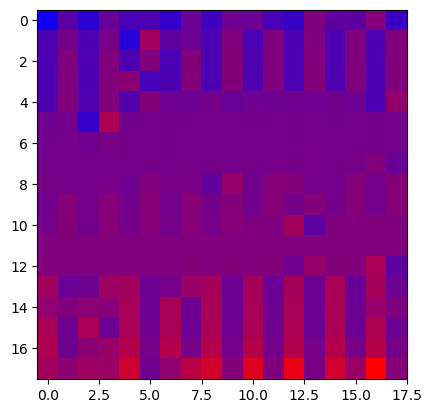

In [38]:
# Visualize the train data loader to see the transformed tensors
J_test_batch_images, J_test_batch_labels = next(iter(J_test_dataloader))

# Use first image in the batch
first_image_in_J_test_batch = J_test_batch_images[0]
image_to_plot = first_image_in_J_test_batch.permute(1, 2, 0).numpy().astype('uint8')

# Visualize the tensor as an image
plt.imshow(image_to_plot)

### Re-define loss function

In [39]:
if LossFunc_Name == 'CrossEntropy':
    loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)

elif LossFunc_Name == 'Focal':
    loss_fn = FocalLoss(gamma=2, alpha=None, reduction='mean')

## Metrics

### Fig 1: training and validation loss

In [40]:
print(f"Best epoch at: {Best_Epoch}")

Best epoch at: 199


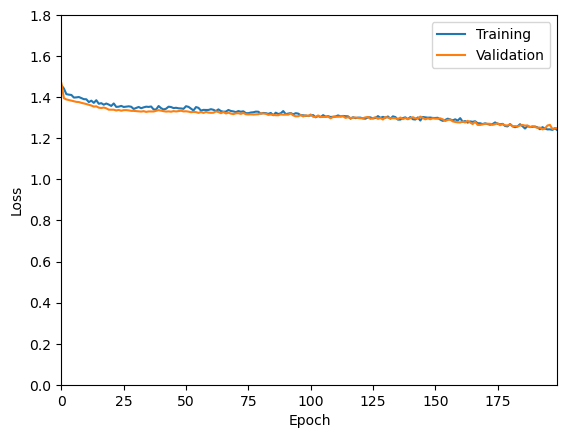

In [41]:
# Graph loss for training and validation
figure1 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainLoss'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValLoss'])
plt.xlim([0,Best_Epoch])
if LossFunc_Name == 'CrossEntropy':
    plt.ylim([0, 1.8])
elif LossFunc_Name == 'Focal':
    plt.ylim([0, 0.3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

### Fig 1.5: gradient norms across training batches

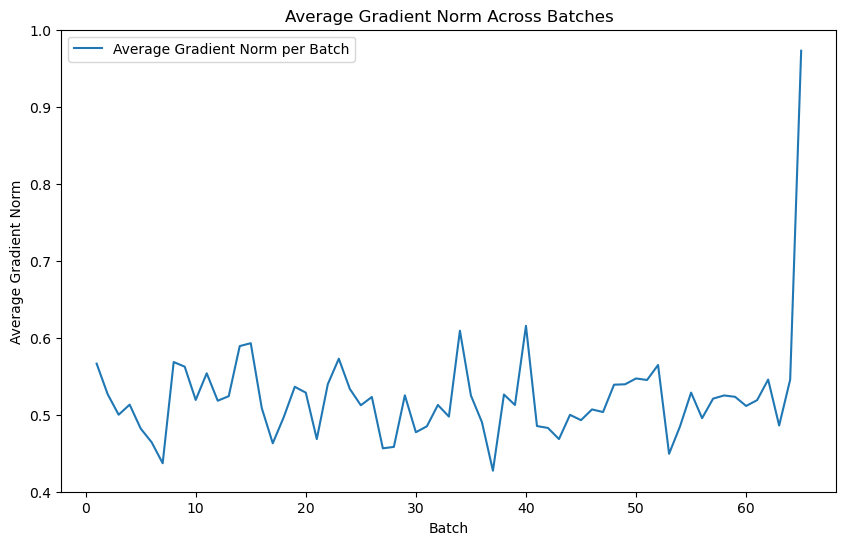

In [42]:
# Calculate the average gradient norm for each batch
average_gradient_norms = [
    sum(norm for _, norm in batch) / len(batch)
    for batch in gradient_norms
]

# Plot the average gradient norm per batch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(average_gradient_norms) + 1), average_gradient_norms, label="Average Gradient Norm per Batch")
plt.xlabel("Batch")
plt.ylabel("Average Gradient Norm")
plt.title("Average Gradient Norm Across Batches")
plt.legend()
plt.show()

### Fig 2: training and validation accuracy

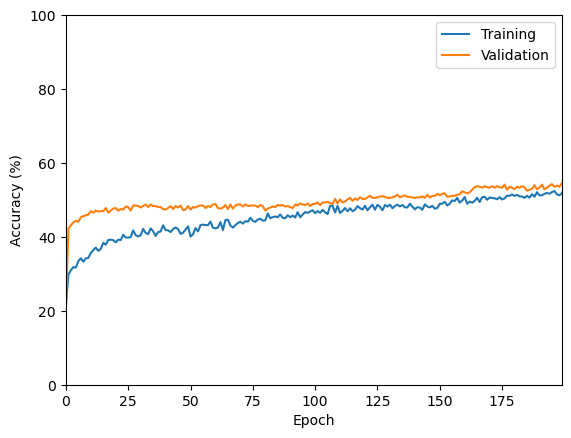

In [43]:
# Graph accuracy for training and validation
figure2 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], (PerformanceDF['TrainAcc'])*100)
plt.plot(PerformanceDF['Epoch'], (PerformanceDF['ValAcc'])*100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xlim([0,Best_Epoch])
plt.ylim([0,100])
plt.legend(['Training', 'Validation'])

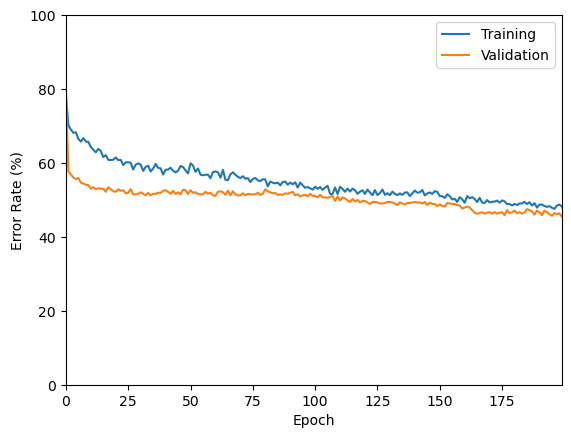

In [44]:
# Graph error rate for training and validation
figure2_5 = plt.gcf()
plt.plot(PerformanceDF['Epoch'], (1-PerformanceDF['TrainAcc'])*100)
plt.plot(PerformanceDF['Epoch'], (1-PerformanceDF['ValAcc'])*100)
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.xlim([0,Best_Epoch])
plt.ylim([0,100])
plt.legend(['Training', 'Validation'])


### Fig 3: validation confusion matrix by best model

Validation accuracy by best model: 0.545
Validation precision by best model: Cytosol 0.603, Mitochondrial 0.107, Nuclear 0.473, Secretory 0.661
Validation recall by best model: Cytosol 0.767, Mitochondrial 0.059, Nuclear 0.557, Secretory 0.239
Validation F1 score by best model is 0.403


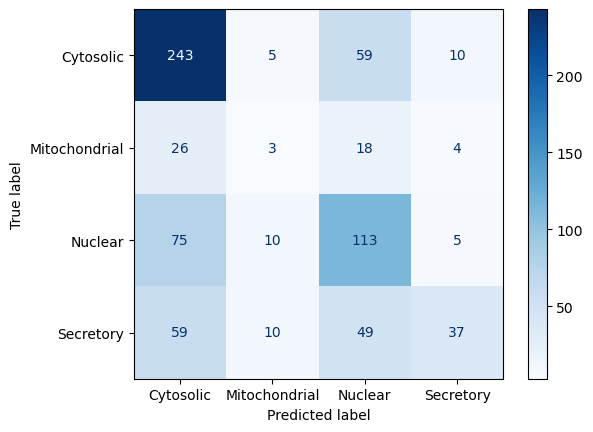

In [45]:
# Load in the best model
if Model == 'CustomNN-reg':
    best_model = SimpleResNet()
    checkpoint = torch.load(Path(model_folder_path+f'best_model_{Run_Name}_{Time_Stamp}.pth'))
    best_model.load_state_dict(checkpoint['model_state_dict'])
elif Model == 'CustomNN-stride2':
    best_model = SimpleResNet2()
    checkpoint = torch.load(Path(model_folder_path+f'best_model_{Run_Name}_{Time_Stamp}.pth'))
    best_model.load_state_dict(checkpoint['model_state_dict'])
elif Model == 'ResNet18':
    best_model = models.resnet18(weights=None)
    best_model.fc = nn.Sequential(
        best_model.fc,
        nn.Dropout(0.5),
        nn.Linear(1000, 4))
    checkpoint = torch.load(Path(model_folder_path+f'best_model_{Run_Name}_{Time_Stamp}.pth'))
    best_model.load_state_dict(checkpoint['model_state_dict'])

best_model.to(device)

# Evalulate validation set (accuracy, F1, confusion matrix)
best_model.eval()
with torch.no_grad():
    # Accuracy
    val_loss, val_accuracy = test_loop(val_dataloader, best_model, loss_fn)
    print(f"Validation accuracy by best model: {round(val_accuracy, 3)}")
    
    # Confusion matrix, precision, recall
    val_cf_matrix, val_precision, val_recall = calculate_precision_recall(val_dataloader, best_model)
    print(f'Validation precision by best model: Cytosol {round(val_precision[0],3)}, Mitochondrial {round(val_precision[1],3)}, Nuclear {round(val_precision[2],3)}, Secretory {round(val_precision[3],3)}')
    print(f'Validation recall by best model: Cytosol {round(val_recall[0],3)}, Mitochondrial {round(val_recall[1],3)}, Nuclear {round(val_recall[2],3)}, Secretory {round(val_recall[3],3)}')

    # F1
    val_f1 = calculate_f1_metrics(val_cf_matrix)
    print(f'Validation F1 score by best model is {round(val_f1, 3)}')

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=val_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
disp.plot(cmap=plt.cm.Blues)
figure3 = plt.savefig(Path(figure_folder_path+f'figure3_val_cm_best_model_{Run_Name}_{Time_Stamp}.png'))

### Fig 4: testing confusion matrics by best model

Skipped predictions (no class > 50%): 11.63%
Confusion Matrix:
[[2887    6    1   21]
 [ 507    0    0    3]
 [1977    5    0    5]
 [1620    6    0   22]]
Johansson testing accuracy by best model: 0.412
Johansson testing precision by best model: Cytosol 0.413, Mitochondrial 0.0, Nuclear 0.0, Secretory 0.431
Johansson testing recall by best model: Cytosol 0.99, Mitochondrial 0.0, Nuclear 0.0, Secretory 0.013
Johansson testing F1 score by best model is 0.304
Skipped predictions (no class > 50%): 11.05%
Confusion Matrix:
[[2138   24    2   27]
 [ 325    1    1    9]
 [1306    0    4    9]
 [ 625   11   14   19]]
Mertins testing accuracy by best model: 0.479
Mertins testing precision by best model: Cytosol 0.487, Mitochondrial 0.028, Nuclear 0.19, Secretory 0.297
Mertins testing recall by best model: Cytosol 0.976, Mitochondrial 0.003, Nuclear 0.003, Secretory 0.028
Mertins testing F1 score by best model is 0.178
Skipped predictions (no class > 50%): 29.59%
Confusion Matrix:
[[1729    3  

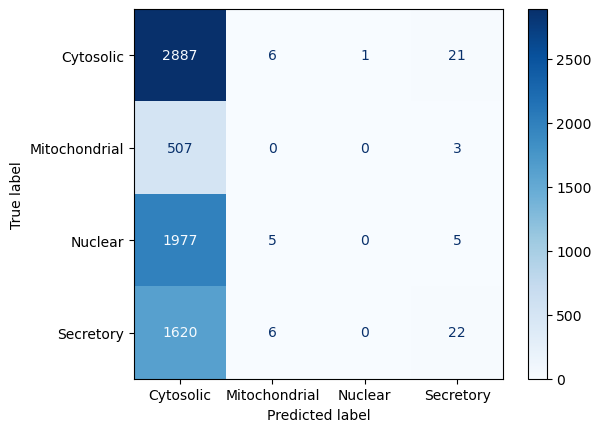

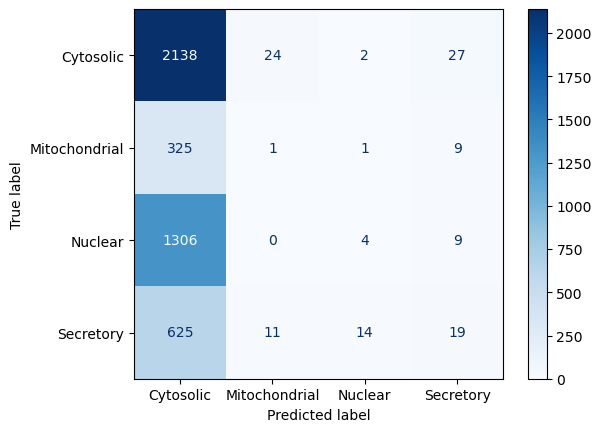

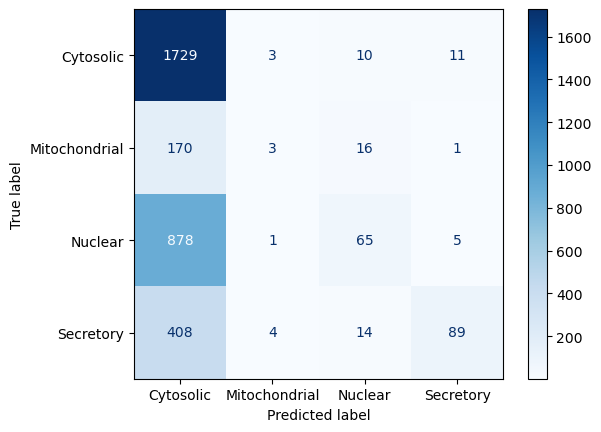

In [46]:
# Slient warnings
warnings.filterwarnings("ignore")

# Evalulate test set (accuracy, precision, recall, F1)
best_model.eval()
with torch.no_grad():
    # Johansson test set
    # Accuracy, precision, recall
    J_test_loss, J_test_accuracy, J_test_cf_matrix, J_precision, J_recall = test_loop_with_confusion_matrix(J_test_dataloader, best_model, loss_fn)
    print(f"Johansson testing accuracy by best model: {round(J_test_accuracy, 3)}")
    if J_test_accuracy == 0:
        pass
    else:
        print(f'Johansson testing precision by best model: Cytosol {round(J_precision[0],3)}, Mitochondrial {round(J_precision[1],3)}, Nuclear {round(J_precision[2],3)}, Secretory {round(J_precision[3],3)}')
        print(f'Johansson testing recall by best model: Cytosol {round(J_recall[0],3)}, Mitochondrial {round(J_recall[1],3)}, Nuclear {round(J_recall[2],3)}, Secretory {round(J_recall[3],3)}')

    # F1
    J_test_f1 = calculate_f1_metrics(J_test_cf_matrix)
    print(f'Johansson testing F1 score by best model is {round(J_test_f1, 3)}')

    # Mertins test set
    # Accuracy, precision, recall
    M_test_loss, M_test_accuracy, M_test_cf_matrix, M_precision, M_recall = test_loop_with_confusion_matrix(M_test_dataloader, best_model, loss_fn)
    print(f"Mertins testing accuracy by best model: {round(M_test_accuracy, 3)}")
    if M_test_accuracy == 0:
        pass
    else:
        print(f'Mertins testing precision by best model: Cytosol {round(M_precision[0],3)}, Mitochondrial {round(M_precision[1],3)}, Nuclear {round(M_precision[2],3)}, Secretory {round(M_precision[3],3)}')
        print(f'Mertins testing recall by best model: Cytosol {round(M_recall[0],3)}, Mitochondrial {round(M_recall[1],3)}, Nuclear {round(M_recall[2],3)}, Secretory {round(M_recall[3],3)}')

    # F1
    M_test_f1 = calculate_f1_metrics(M_test_cf_matrix)
    print(f'Mertins testing F1 score by best model is {round(M_test_f1, 3)}')

    # Krug test set
    # Accuracy, precision, recall
    K_test_loss, K_test_accuracy, K_test_cf_matrix, K_precision, K_recall = test_loop_with_confusion_matrix(K_test_dataloader, best_model, loss_fn)
    print(f"Krug testing accuracy by best model: {round(K_test_accuracy, 3)}")
    if K_test_accuracy == 0:
        pass
    else:
        print(f'Krug testing precision by best model: Cytosol {round(K_precision[0],3)}, Mitochondrial {round(K_precision[1],3)}, Nuclear {round(K_precision[2],3)}, Secretory {round(K_precision[3],3)}')
        print(f'Krug testing recall by best model: Cytosol {round(K_recall[0],3)}, Mitochondrial {round(K_recall[1],3)}, Nuclear {round(K_recall[2],3)}, Secretory {round(K_recall[3],3)}')

    # F1
    K_test_f1 = calculate_f1_metrics(K_test_cf_matrix)
    print(f'Krug testing F1 score by best model is {round(K_test_f1, 3)}')

# Display the confusion matrices side by side
if J_test_accuracy == 0:
    pass
else:
    disp_J = ConfusionMatrixDisplay(confusion_matrix=J_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
    disp_J.plot(cmap=plt.cm.Blues)
if M_test_accuracy == 0:
    pass
else:
    disp_M = ConfusionMatrixDisplay(confusion_matrix=M_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
    disp_M.plot(cmap=plt.cm.Blues)
if K_test_accuracy == 0:
    pass
else:
    disp_K = ConfusionMatrixDisplay(confusion_matrix=K_test_cf_matrix, display_labels=['Cytosolic', 'Mitochondrial', 'Nuclear', 'Secretory'])
    disp_K.plot(cmap=plt.cm.Blues)

### Fig 5: Precision and recall of validation and testing

#### 95% CI simulation

In [47]:
# Set 1000 seeds to get the initial precision and recall for thousand times
num_of_seeds = list(range(100, 100+1000))
index = 0
InitialPrecisionRecallDF = pd.DataFrame(columns=['Seed', 'Class', 'Precision', 'Recall'])

# We will shuffle the validation dataloader
shuffle_val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

# Loop through the seeds to get the initial precision and recall
for t in num_of_seeds:
    set_seed(t)
    
    # Determine the model
    if Model == 'CustomNN-reg':
        model_for_ci = SimpleResNet()
    elif Model == 'CustomNN-stride2':
        model_for_ci = SimpleResNet2()
    elif Model == 'CustomNN-mini':
        model_for_ci = SimpleResNet_Mini()
    else:
        raise ValueError("Model must be 'CustomNN-reg', 'CustomNN-stride2', or 'CustomNN-mini'")

    model_for_ci.to(device)

    # Get initial model precision and recall for each class
    cf, precision, recall = calculate_precision_recall(shuffle_val_dataloader, model_for_ci)
    
    # Record the initial precision and recall
    for i in range(4):
        InitialPrecisionRecallDF.loc[index]=[t, i, precision[i], recall[i]]
        index += 1

    # Print out t to keep track of the progress, if t is divisible by 100
    if t % 100 == 0:
        print(t)
    
print("done!")

100
200
300
400
500
600
700
800
900
1000
done!


#### Simulation result

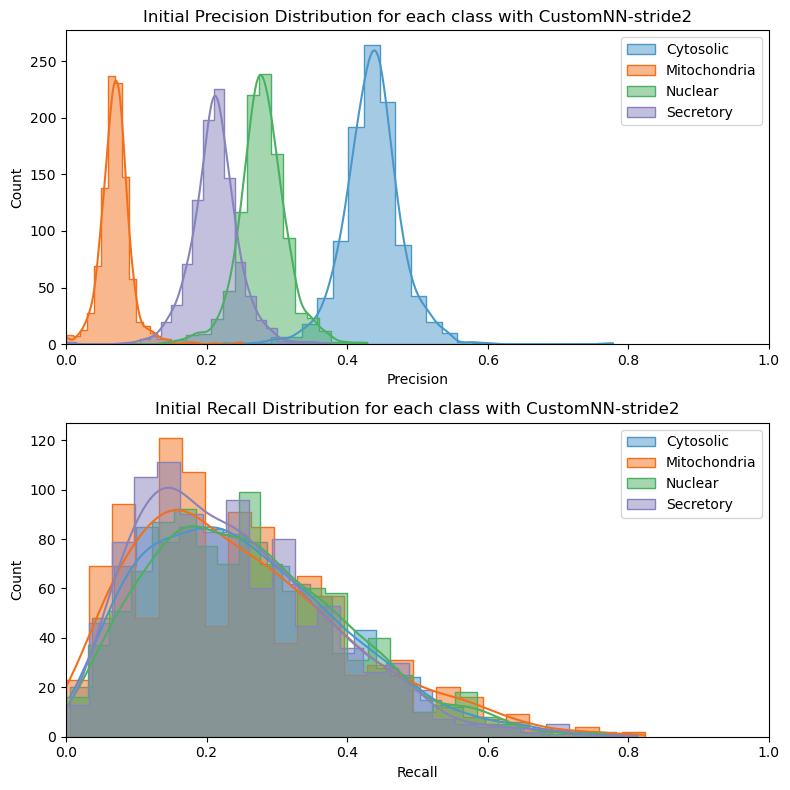

In [48]:
warnings.filterwarnings('ignore')

# Silent the warning
pd.options.mode.chained_assignment = None

# Assign class names
class_names = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']

# Visualize the precision distribution for each class in a histogram
fig, axes = plt.subplots(2,1,figsize=(8, 8))

# Define colormaps for each class
colormaps = [cm.Blues, cm.Oranges, cm.Greens, cm.Purples]

# Visualize the precision distribution for each class in a histogram
for i, class_name in enumerate(class_names):
    sns.histplot(data=InitialPrecisionRecallDF[InitialPrecisionRecallDF['Class'] == i], 
                 x='Precision', kde=True, bins=25, element='step', ax=axes[0], color=colormaps[i](0.6), label=class_name)
axes[0].set_title(f'Initial Precision Distribution for each class with {Model}')
axes[0].set_xlim(0, 1)
axes[0].legend()

# Visualize the recall distribution for each class in a histogram
for i, class_name in enumerate(class_names):
    sns.histplot(data=InitialPrecisionRecallDF[InitialPrecisionRecallDF['Class'] == i], 
                 x='Recall', kde=True, bins=25, element='step', ax=axes[1], color=colormaps[i](0.6), label=class_name)
axes[1].set_title(f'Initial Recall Distribution for each class with {Model}')
axes[1].set_xlim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

#### Simulated 95% CI dataframe

In [49]:
# Drop seed column in InitialPrecisionRecallDF
InitialPrecisionRecallDF = InitialPrecisionRecallDF.drop(columns='Seed')

# Make a copy of the dataframe
InitialPrecisionRecallDF_copy = InitialPrecisionRecallDF.copy()

# Create a new dataframe to store the mean precision, median recall, 50th and 950th sorted precision and recall for each class
InitialPrecisionRecallStats = pd.DataFrame(columns=['Class', 'Mean Precision', 'Mean Recall', '0th Precision', '950th Precision', '0th Recall', '950th Recall'])

# Add these metrics into the dataframe
for i in range(4):
    class_precision = InitialPrecisionRecallDF_copy[InitialPrecisionRecallDF_copy['Class'] == i]['Precision'].sort_values().values
    class_recall = InitialPrecisionRecallDF_copy[InitialPrecisionRecallDF_copy['Class'] == i]['Recall'].sort_values().values
    InitialPrecisionRecallStats.loc[i] = [
        ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory'][i], 
        InitialPrecisionRecallDF[InitialPrecisionRecallDF['Class'] == i]['Precision'].mean(), 
        InitialPrecisionRecallDF[InitialPrecisionRecallDF['Class'] == i]['Recall'].mean(),
        class_precision[0],  # 0th element (index 0)
        class_precision[949],  # 950th element (index 949)
        class_recall[0],  # 0th element (index 0)
        class_recall[949]  # 950th element (index 949)
    ]

InitialPrecisionRecallStats

,Class,Mean Precision,Mean Recall,0th Precision,950th Precision,0th Recall,950th Recall
0,Cytosolic,0.435510,0.251625,0.225,0.500000,0.006309,0.504732
1,Mitochondria,0.070933,0.247863,0.000,0.103896,0.000000,0.549020
2,Nuclear,0.279349,0.259522,0.000,0.337662,0.000000,0.527094
3,Secretory,0.211977,0.238839,0.000,0.267241,0.000000,0.483871


#### Graphing

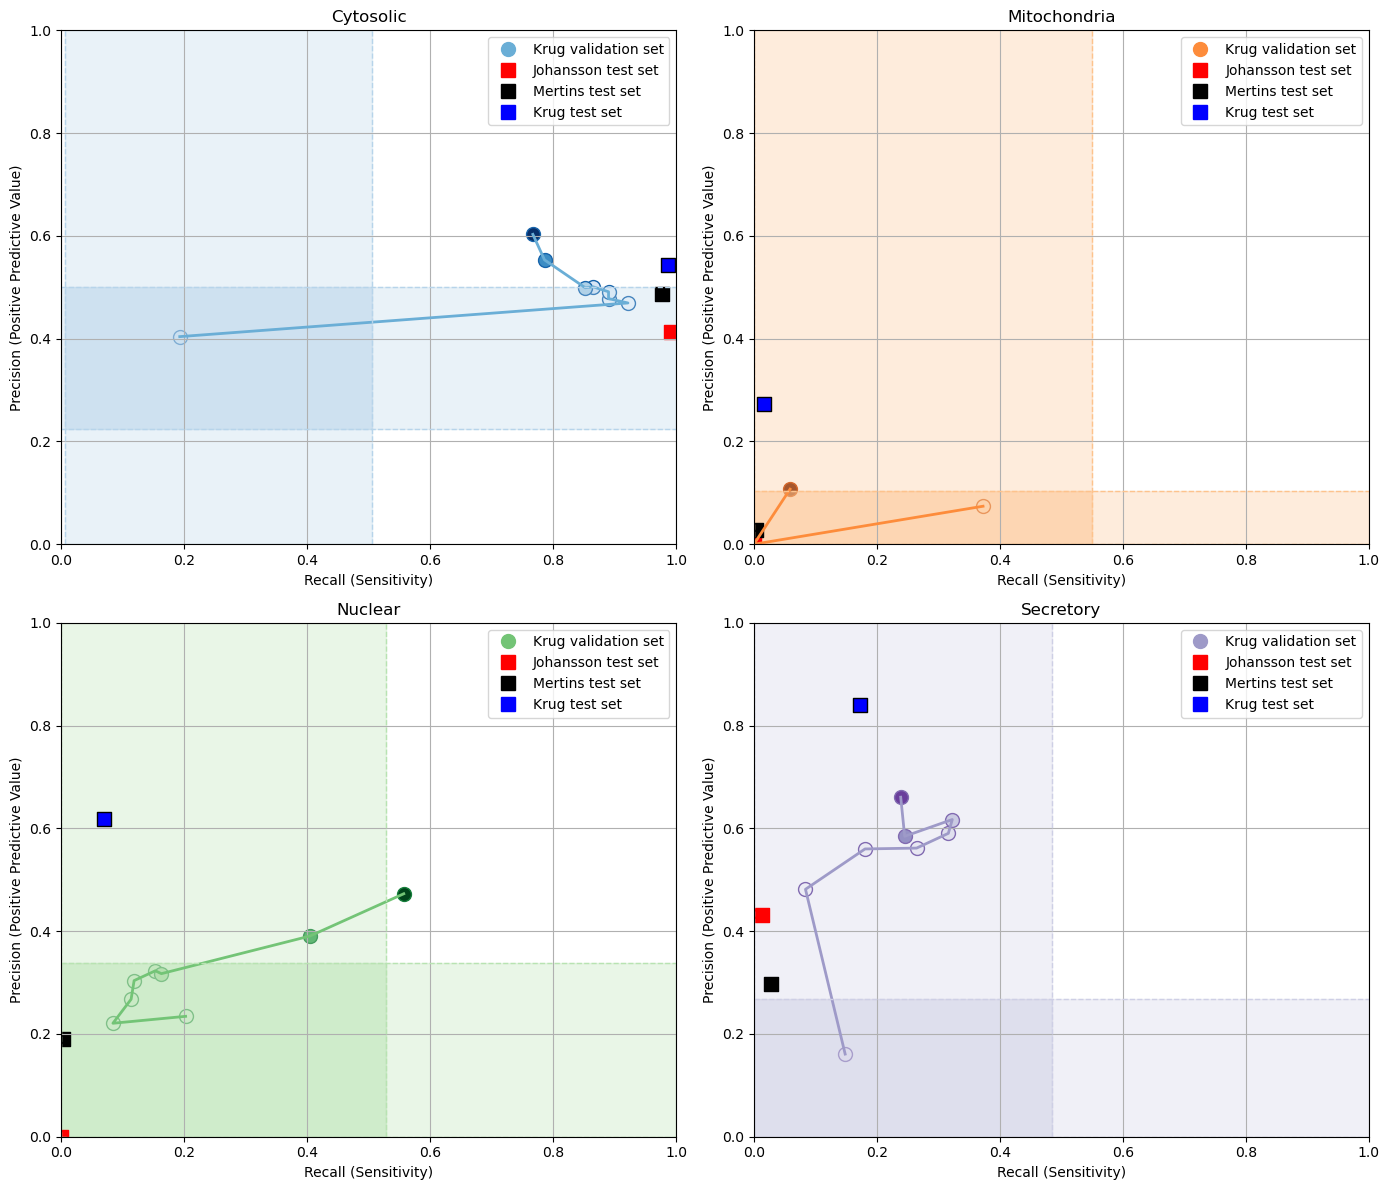

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
compartment_class = ['Cytosolic', 'Mitochondria', 'Nuclear', 'Secretory']
colormaps = [cm.Blues, cm.Oranges, cm.Greens, cm.Purples]

# Use a floor(X^x) to determine which epoch to plot, plot the epoch 0 and Best_epoch
epoch_to_plot = [0] # Start with epoch 0
for x in range(0, 100):
    if math.floor(2**x) == 1:
        pass
    elif math.floor(2**x) == 2:
        pass
    elif math.floor(2**x) > Best_Epoch:
        break
    else:
        epoch_to_plot.append(math.floor(2**x))

epoch_to_plot.append(Best_Epoch) # Add the best epoch at the end

# Filter out epochs in PrecisionRecallDF using the epoch_to_plot
PrecisionRecallDF_subset = PrecisionRecallDF[PrecisionRecallDF['Epoch'].isin(epoch_to_plot)]

# Read in the ci_metrics
CI_PrecisionRecallDF = InitialPrecisionRecallStats

for i, ax in enumerate(axes.flatten()):
    class_metrics = PrecisionRecallDF_subset[PrecisionRecallDF_subset['Class'] == i]
    ci_metrics = CI_PrecisionRecallDF[CI_PrecisionRecallDF['Class'] == compartment_class[i]]

    # Normalize epoch for color mapping
    norm = plt.Normalize(class_metrics['Epoch'].min(), class_metrics['Epoch'].max())

    # Scatter plot with gradient color based on epoch
    for idx, row in class_metrics.iterrows():
        color = colormaps[i](norm(row['Epoch']))
        edge_color = colormaps[i](0.8)
        ax.scatter(row['Recall'], row['Precision'], s=100, color=color, edgecolors=edge_color, linewidths=1)

    # Connect the dots with colored lines
    ax.plot(class_metrics['Recall'], class_metrics['Precision'], color=colormaps[i](0.5), linewidth=2)

    # Plot the 0th and 950th precision and recall as shaded area
    ax.axhline(y=ci_metrics['0th Precision'].values[0], color=colormaps[i](0.3), linestyle='--', linewidth=1)
    ax.axhline(y=ci_metrics['950th Precision'].values[0], color=colormaps[i](0.3), linestyle='--', linewidth=1)
    ax.axvline(x=ci_metrics['0th Recall'].values[0], color=colormaps[i](0.3), linestyle='--', linewidth=1)
    ax.axvline(x=ci_metrics['950th Recall'].values[0], color=colormaps[i](0.3), linestyle='--', linewidth=1)
    ax.fill_betweenx([ci_metrics['0th Precision'].values[0], ci_metrics['950th Precision'].values[0]],
                        ci_metrics['0th Recall'].values[0], ci_metrics['950th Recall'].values[0],
                        color=colormaps[i](0.3), alpha=0.3)

    # Fill the entire area between hline and vline
    ax.fill_betweenx([0, 1], ci_metrics['0th Recall'].values[0], ci_metrics['950th Recall'].values[0], color=colormaps[i](0.3), alpha=0.3)
    ax.fill_between([0, 1], ci_metrics['0th Precision'].values[0], ci_metrics['950th Precision'].values[0], color=colormaps[i](0.3), alpha=0.3)

    ax.set_title(compartment_class[i])
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision (Positive Predictive Value)')
    ax.grid(True)

    # Add in a scatter dot to label the precision and recall of testing set
    ax.scatter(J_recall[i], J_precision[i], s=100, color='red', edgecolors='red', linewidths=1, marker='s')
    ax.scatter(M_recall[i], M_precision[i], s=100, color='black', edgecolors='black', linewidths=1, marker='s')
    ax.scatter(K_recall[i], K_precision[i], s=100, color='blue', edgecolors='black', linewidths=1, marker='s')

    # Create custom legend handles
    krug_handle = mlines.Line2D([], [], color=colormaps[i](0.5), marker='o', linestyle='None', markersize=10, label='Krug validation set')
    johansson_handle = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Johansson test set')
    mertins_handle = mlines.Line2D([], [], color='black', marker='s', linestyle='None', markersize=10, label='Mertins test set')
    krug_test_handle = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=10, label='Krug test set')

    # Add a legend
    ax.legend(handles=[krug_handle, johansson_handle, mertins_handle, krug_test_handle], loc='upper right')

plt.tight_layout()
plt.show()

figure5 = fig.savefig(figure_folder_path + f'figure5_precision_recall_{Run_Name}_{Time_Stamp}.png')

## Summary

### Summary output

In [51]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Image, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from IPython.display import display, HTML

# Define the parameters
parameters = {
    'Run Name': Run_Name,
    'Seed': Seed,
    'Set': Set,
    'Canvas size': Canvas_Size,
    'Validation Fraction': Validation_Fraction,
    'Standard deviation in add-noise transformation': StandardDeviation,
    'Model': Model,
    'Weight Decay (L2)': Weight_Decay,
    'Momentum': Momentum if Optim_Name == 'SGD_weight' else 'None',
    'Loss Function': LossFunc_Name,
    'Optimizer': Optim_Name,
    'Learning Rate': Learner_rate,
    'LR Scheduler?': LrScheduler,
    'Label Smoothing': Label_Smoothing,
    'Class Weights': LossWeights if ApplyClassWeightToLoss else 'None',
    'Batch Size': batch,
    'Epoch': epochs,
    'Best Epoch': Best_Epoch,
    'Early stopping?': Earlystopping,
    'Transformed?': TransformOrNot,
    'Training sample balanced?': ImbalanceSampler,
    'Best Validation accuracy': round(val_accuracy, 3),
    'Validation macro-avg F1 score': round(val_f1, 3),
    'Validation precision': np.round(val_precision, 3),
    'Validation recall': np.round(val_recall, 3),
    'Johansson Test accuracy with best model': round(J_test_accuracy, 3),
    'Johansson precision': np.round(J_precision, 3),
    'Johansson recall': np.round(J_recall, 3),
    'Johansson F1 score': round(J_test_f1, 3),
    'Mertins Test accuracy with best model': round(M_test_accuracy, 3),
    'Mertins precision': np.round(M_precision, 3),
    'Mertins recall': np.round(M_recall, 3),
    'Mertins F1 score': round(M_test_f1, 3),
}

# Define the PDF file
summary_file = Path(summary_folder_path+f'parameter_summary_{Run_Name}_{Time_Stamp}.pdf')
doc = SimpleDocTemplate(str(summary_file), pagesize=letter)

# Define the content
content = []

# Define a custom style with a specific font size
styles = getSampleStyleSheet()
custom_style = ParagraphStyle(
    'CustomStyle',
    parent=styles['Normal'],
    fontSize=10,  # Specify the font size
)
caption_style = ParagraphStyle(
    'CaptionStyle',
    parent=styles['Normal'],
    fontSize=10,  # Specify the font size for captions
)

# Add the parameter summary to the content
content.append(Paragraph('Parameter Summary:', styles['Title']))
for key, value in parameters.items():
    content.append(Paragraph(f'{key}: {value}', custom_style))
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

# Save the figures and include them in the content
figure1.savefig(Path(figure_folder_path+f'figure1_loss_{Run_Name}_{Time_Stamp}.png'), dpi=300, bbox_inches='tight')
figure2.savefig(Path(figure_folder_path+f'figure2_accuracy_{Run_Name}_{Time_Stamp}.png'), dpi=300, bbox_inches='tight')
content.append(Paragraph('Figures:', styles['Title']))

img1 = Image(Path(figure_folder_path+f'figure1_loss_{Run_Name}_{Time_Stamp}.png'))
img1.drawHeight = 6*inch*img1.drawHeight / img1.drawWidth
img1.drawWidth = 6*inch
content.append(img1)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img2 = Image(Path(figure_folder_path+f'figure2_accuracy_{Run_Name}_{Time_Stamp}.png'))
img2.drawHeight = 6*inch*img2.drawHeight / img2.drawWidth
img2.drawWidth = 6*inch
content.append(img2)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img3 = Image(Path(figure_folder_path+f'figure3_val_cm_best_model_{Run_Name}_{Time_Stamp}.png'))
img3.drawHeight = 6*inch*img3.drawHeight / img3.drawWidth
img3.drawWidth = 6*inch
content.append(img3)
content.append(Spacer(1, 0.2 * inch))  # Add a blank line

img5 = Image(Path(figure_folder_path+f'figure5_precision_recall_{Run_Name}_{Time_Stamp}.png'))
img5.drawHeight = 6*inch*img5.drawHeight / img5.drawWidth
img5.drawWidth = 6*inch
content.append(img5)

# Build the PDF
doc.build(content)

# Print a message indicating that the parameter summary and figures have been saved
print('Parameter summary and figures have been saved.')
display(HTML('<a href="{}" target="_blank">Click here to download {}</a>'.format(summary_file, summary_file)))

Parameter summary and figures have been saved.


In [52]:
# export dataframes
PerformanceDF.to_excel(Path(performance_folder_path + f'PerformanceDF_{Time_Stamp}.xlsx'), index=False)
PrecisionRecallDF.to_excel(Path(performance_folder_path + f'PrecisionRecallDF_{Time_Stamp}.xlsx'), index=False)